# Random Forest

In [52]:
%config IPCompleter.greedy=True
import helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, tree, linear_model
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
#pd.DataFrame(result_pd_RF).to_csv('resultRF.csv',index = False)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import os
%matplotlib inline 
import pylab 
import scipy.stats as stats
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
plt.style.use('ggplot')
#This line force the graph print out in this jupyter Notebook

In [53]:
testset = pd.read_csv('test.csv')
trainset = pd.read_csv('train.csv')
trainset.isnull().sum()
## Some features have almost all null in every rows, so I will remove null> 1000 for cleaning the features a little bit.
features = trainset.columns.values
remove_features = trainset.columns[trainset.isnull().sum()>1000]
testset = testset.drop(remove_features,1)
testset_id = testset['Id']
testset = testset.drop('Id', 1)
trainset_id = trainset['Id']
trainset = trainset.drop('Id', 1)
## GarageCars has a higher correlation, so Garage Area and GarageYearBlt will be dropped.
## TotalBsmtSF has a higher correlation with 1stFlrSF, so it will be dropped as well.
trainset = trainset.drop(['1stFlrSF','GarageArea','GarageYrBlt'],1)
testset = testset.drop(['1stFlrSF','GarageArea','GarageYrBlt'],1)

## Drop some columns that only have 1 class for most data
drop_cols = ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']
trainset = trainset.drop(drop_cols, 1)
testset = testset.drop(drop_cols, 1)
trainset['MSSubClass'] = trainset['MSSubClass'].astype('category')
testset['MSSubClass'] = testset['MSSubClass'].astype('category')
#low_var_cat = [col for col in train.select_dtypes(exclude=['number']) if 1 - sum(train[col] == mode(train[col]))/len(train) < 0.03]
#low_var_cat


trainset['SalePrice'] =np.log(trainset['SalePrice'])
train_labels = trainset['SalePrice']
trainset = trainset.drop('SalePrice',1)

from sklearn.model_selection import train_test_split
testset_index = range(len(trainset),len(trainset) + len(testset))

trainset_index, validset_index = train_test_split(range(len(trainset)),
                                    random_state = 42 , test_size = 0.3)
masterset = pd.concat([trainset,testset], axis = 0)
masterset_backup = masterset
# Getting Dummies from all other categorical vars
for col in masterset.dtypes[masterset.dtypes == 'object'].index:
    for_dummy = masterset.pop(col)
    masterset = pd.concat([masterset, pd.get_dummies(for_dummy, prefix=col)], axis=1)
    train_labels_full = train_labels
    
## Drop columns which has very few sample in trainset/testset
#a=masterset.iloc[testset_index].sum()
#b=masterset.iloc[range(len(trainset))].sum()
trainset_nonexist_features = masterset.iloc[range(len(trainset))].sum()<10
testset_nonexist_features = masterset.iloc[testset_index].sum()<10
nonexist_features = masterset.columns[trainset_nonexist_features |
                                      testset_nonexist_features].values
masterset= masterset.drop(nonexist_features, axis = 1)


train_features_full = masterset.iloc[range(len(trainset))]
train_features = masterset.iloc[trainset_index] 
test_features = masterset.iloc[testset_index]
valid_features = masterset.iloc[validset_index]

## Take a copy of it will be a reference of train_labels
valid_labels = train_labels[validset_index].copy() 
train_labels = train_labels[trainset_index]

col = train_features.columns.values
print(train_features.shape)
print(test_features.shape)

(1022, 197)
(1459, 197)


In [79]:
## RandomForest
from sklearn.ensemble import RandomForestRegressor
## Model
RF = RandomForestRegressor( 
                           n_jobs = 4, random_state = 42 )
PipeRF = Pipeline([
        ('imp',Imputer()),
        ('std', MinMaxScaler()),
        ('RF', RF)
    ])
# estimator parameters
n_estimators = [1000]
components = []

minsamplesleaf = [2]
max_features =[0.4]
max_depth = [13]
param_grid_RF={'RF__n_estimators' : n_estimators,
               'RF__max_depth' : max_depth,
               'RF__max_features' : max_features,
               'RF__min_samples_leaf' : minsamplesleaf,
             'imp__strategy': ['median'] 
              }

# set model parameters to grid search object
gridCV_RF = GridSearchCV(estimator = PipeRF, 
                         param_grid = param_grid_RF,
                         scoring = 'neg_mean_squared_error',
                         cv = 3)
        
# train the model
gridCV_RF.fit(train_features, train_labels)
print(gridCV_RF.best_params_)


{'RF__min_samples_leaf': 2, 'RF__max_depth': 13, 'RF__max_features': 0.4, 'imp__strategy': 'median', 'RF__n_estimators': 1000}


In [80]:
(gridCV_RF.best_score_*-1)**0.5

0.1441756110307931

Cross Val (Train set) [ 0.1353096   0.17167688  0.1623615   0.13608595  0.11381039]
Cross Val (valid set) [ 0.13204188  0.16850803  0.19869202  0.11339875  0.12595944]
Accuracy Val(Train set) 0.970945035343
Accuracy Val (Valid set) 0.889566097001
Root Mean Squarted Log Error (Train set):  0.0671094896547
Root Mean Squarted Log Error (Valid set):  0.13687471691


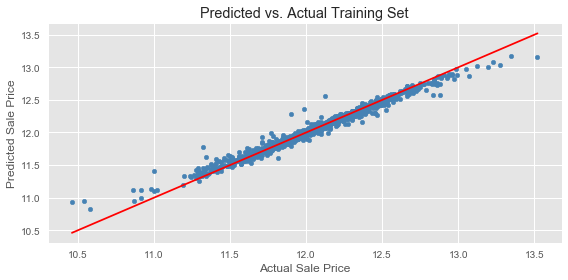

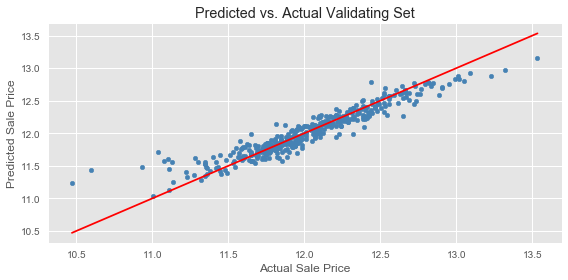

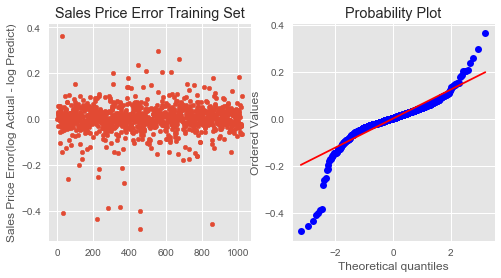

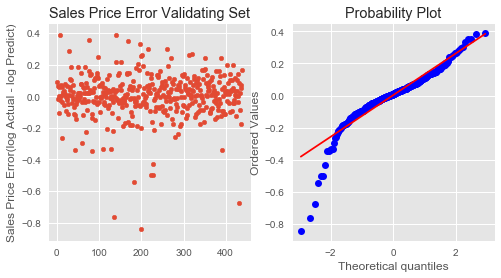

In [81]:
## Running test
helper.summary(gridCV_RF.best_estimator_,train_features, train_labels, valid_features, valid_labels)

In [82]:
import importlib
importlib.reload(helper)
import helper

## Use the paramater refit the entire dataset

In [85]:
model_RF = gridCV_RF.best_estimator_.fit(train_features_full, train_labels_full)

In [84]:
import pickle
# Save the model if rerun above cell for searching hyperparameters
#with open('model_RF.pkl', 'wb') as source:    
#  s = pickle.dump(gridCV_RF.best_estimator_, source)

## Fit a logistic regression on the RF model as it is heavily tailed

In [86]:
with open('model_RF.pkl','rb') as load:
    model_RF = pickle.load(load)

result_RF = model_RF.predict(train_features_full)
result_RF_test = model_RF.predict(test_features)

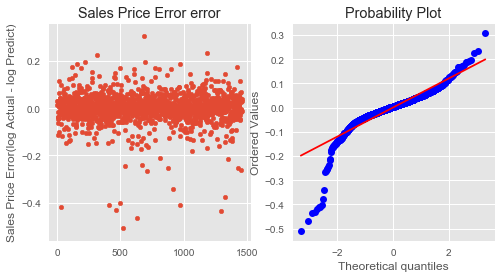

In [87]:
helper.error_plot(train_labels_full, result_RF, 'error')

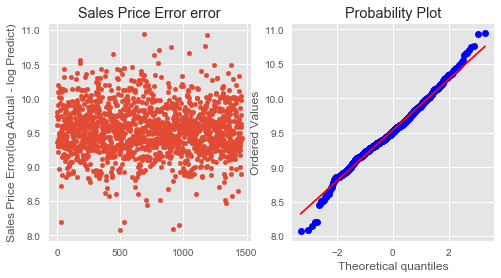

In [90]:
## Log transform help predicting
helper.error_plot(train_labels_full, np.log(result_RF), 'error')

In [91]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(np.log(result_RF.reshape([-1,1])), train_labels_full)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [92]:
result_RF=linear.predict(np.log(result_RF_test.reshape([-1,1])))

In [93]:
#result_RF = gridCV_RF.best_estimator_.predict(test_features.fillna(-1))
## Output result, match the require format
result_pd= pd.DataFrame(np.array(list(zip(testset_index,result_RF))),
                        columns=['Id','SalePrice']) ## Id start from 1
result_pd.Id = result_pd.Id.astype('int') + 1 ## Id = index + 1
result_pd['SalePrice'] = result_pd['SalePrice'].apply(lambda x: np.e**(x))

pd.DataFrame(result_pd).to_csv('resultRF.csv',index = False)
result_pd[0:5]

,Id,SalePrice
0,1461,120698.224064
1,1462,153772.507198
2,1463,179924.510629
3,1464,185847.156613
4,1465,195500.859552
